In [18]:
import os
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
llm_api_key=os.getenv("deepseekkey")
finance_key=os.getenv('financekey')
# print(llm_api_key,finance_key)


In [19]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import requests
import numpy as np

URL="https://www.alphavantage.co/query"

@tool
def stockprice(stock_name:str)->float:
    """ returns the stock price for the given stock name for the day """
    params = {
    "function": "TIME_SERIES_INTRADAY",
    "symbol": stock_name,
    "apikey": finance_key  # Replace with your actual API key
    }
    response = requests.get(URL, params=params)
    data = response.json()
    for  i in data['Time Series (Daily)']:
        mean=abs(np.mean([float(data['Time Series (Daily)'][i]['1. open']),float(data['Time Series (Daily)'][i]['4. close'])]))
        break
    # print(mean)
    return mean

@tool
def stockdetail(stock_name:str)->str:
    '''returns information of the given stock name'''
    params={
        "function":"OVERVIEW",
        "symbol":stock_name,
        "apikey":finance_key
    }
    response = requests.get(URL, params=params)
    data = response.json()
    # print(f"discription: {data['Description']}\nsector: {data['Sector']}")
    return f"discription: {data['Description']}\nsector: {data['Sector']}"

tools=[stockdetail,stockprice]
toolnode=ToolNode(tools=tools)

In [20]:
from langchain_openai import ChatOpenAI
model= ChatOpenAI(model="deepseek/deepseek-chat-v3-0324:free",api_key=llm_api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools=tools)

In [21]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage], add_messages]


def decision1(state:Agent):
    a=input("should continue")
    if a=="no":
        return "end"
    else:
        return "continue"

def decision2(state:Agent):
    if getattr(state['message'][-1],'tool_calls'):
        return 'tools'
    return "print"

def llm_node(state: Agent)->Agent:
    systemprompt=[SystemMessage(content=f"""
    You are a finance assistent that helps answers the user's queries.you have a set of tools which are
    stockprice: use this tool get price of a stock the input requires precise stock name.
    stockdetail: use this tool to get infromation of the company of the stock the input requires precise stock name.                             
    """),
    HumanMessage(content=input("enter the message"))]
    response = model.invoke(systemprompt)
    return {"message": [response]}

def preetyprint(state:Agent)->Agent:
    print(state['message'])
    return{'message':[]}

In [22]:
graph=StateGraph(Agent)
graph.add_node('dec1',lambda state:state)
graph.add_node('dec2',lambda state:state)
graph.add_node('llm',llm_node)
graph.add_node('tools',toolnode)
graph.add_node('print',preetyprint)
graph.set_entry_point('dec1')
graph.add_conditional_edges('dec1',
                            decision1,
                            {
                                "continue":"llm",
                                "end": END,
                            }
                            )
graph.add_edge('llm','dec2')
graph.add_conditional_edges('dec2',
                            decision2,
                            {
                                "tools":"tools",
                                "print":"print",
                            }
                            )
graph.add_edge('tools','print')
graph.add_edge('print','dec1')
app=graph.compile()

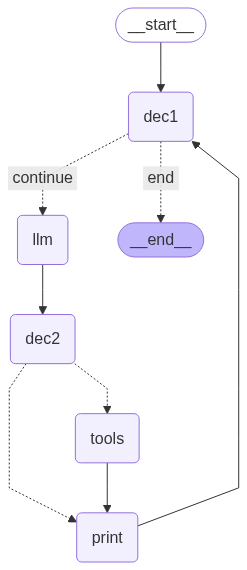

In [23]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
res=app.invoke({'message':[]})
print('f =',res)

ValueError: No message found in input